<a href="https://colab.research.google.com/github/aishwarya-shekar-babu/MLP-Performance-Analysis/blob/main/MLP_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install keras

# Importing Necessary libraries

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras import callbacks
from keras import optimizers
import copy
import random

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)



# Reading Dataset

In [28]:
# Load dataset
df = pd.read_csv("german_credit_data.csv")
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


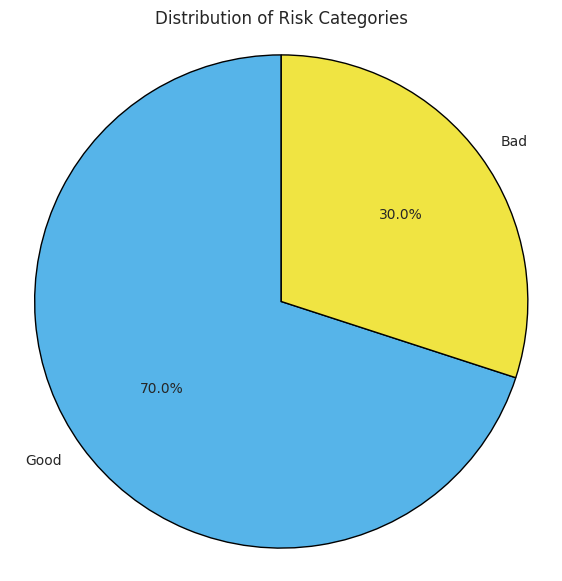

In [29]:
# Count occurrences of 'good' and 'bad'
risk_counts = df['Risk'].value_counts()

# Data: Counts of 'good' and 'bad' categories
labels = ['Good', 'Bad']
colors = ['#56B4E9', '#F0E442']  # Color Universal Design colors: Blue and Yellow

# Create the pie chart
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(risk_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Title
plt.title('Distribution of Risk Categories')

# Display the chart
plt.show()



# Data Preparation

## Data Cleaning and Processing

In [30]:
#dropping uncessary column
df = df.drop('Unnamed: 0', axis=1)

# Handle missing values
df.fillna("unknown", inplace=True)

# Convert target variable 'Risk' to binary (good: 0, bad: 1)
df["Risk"] = df["Risk"].map({"good": 0, "bad": 1})
df.head()

# Separate features and target for further analysis
X = df.drop(columns=["Risk"])
y = df["Risk"]

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()


## Enconding and feature scaling

In [31]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Transform features
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_transformed = pipeline.fit_transform(X)
X_transformed = np.array(X_transformed)

## Train,test and validate split

In [32]:
# Split dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)


## Data Formating

In [33]:
X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
X_val_copy = X_val.copy()
y_val_copy = y_val.copy()
X_test_copy = X_test.copy()
y_test_copy = y_test.copy()

# Intilisation with creation of balanced data

In [34]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to integers or round the values
class_weights_dict = {i: float(weight) for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7142857142857143, 1: 1.6666666666666667}


# Analysis of MLP model without hypertuning

## Building a simple MLP model without hypertuning

In [35]:
# Function to build a simple MLP model (No dropout, regularization, or early stopping)
def build_simple_mlp(depth=2, width=64):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))  # Input Layer

    # Add hidden layers (Simple Dense Layers with ReLU)
    for _ in range(depth):
        model.add(layers.Dense(width, activation='relu'))

    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Training a simple MLP model without hypertuning

In [36]:
# Function to train and evaluate the simple MLP model
def train_simple_mlp(X_train, y_train, X_val, y_val, X_test, y_test, depth, width, epochs=50, batch_size=32):
    print(f"\nTraining Simple MLP Model with Depth={depth}, Width={width}")

    # Build the model
    model = build_simple_mlp(depth=depth, width=width)

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val))

    # Predict on test set
    y_pred = (model.predict(X_test, batch_size=batch_size, verbose=0) > 0.5).astype("int32")

    # Calculate evaluation metrics
    results = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred)
    }

    print(f"Accuracy: {results['Accuracy']:.4f}, Precision: {results['Precision']:.4f}, "
          f"Recall: {results['Recall']:.4f}, F1-Score: {results['F1-Score']:.4f}, "
          f"ROC-AUC: {results['ROC-AUC']:.4f}\n")

    return results


## Experimenting a simple MLP model without hypertuning

In [37]:
# Function to run experiments with different depths and widths
def run_simple_mlp_experiments(X_train, y_train, X_val, y_val, X_test, y_test, depths, widths, epochs=50, batch_size=32):
    results = []  # Store results for all experiments

    for depth in depths:
        for width in widths:
            try:
                # Train and evaluate model
                metrics = train_simple_mlp(X_train, y_train, X_val, y_val, X_test, y_test, depth, width, epochs, batch_size)

                # Store results
                results.append({
                    'Depth': depth,
                    'Width': width,
                    'Accuracy': metrics['Accuracy'],
                    'Precision': metrics['Precision'],
                    'Recall': metrics['Recall'],
                    'F1-Score': metrics['F1-Score'],
                    'ROC-AUC': metrics['ROC-AUC']
                })

                print(f"Completed: Depth={depth}, Width={width}, AUC-ROC={metrics['ROC-AUC']:.4f}")

            except Exception as e:
                print(f"Error with Depth={depth}, Width={width}: {e}")

    return pd.DataFrame(results)  # Convert results to DataFrame for easy visualization

# Define different depths and widths to experiment with
depths = [2, 3, 4]  # Number of hidden layers
widths = [32, 64, 128,256]  # Number of neurons per layer

# Run experiments and store results
simple_mlp_results = run_simple_mlp_experiments(X_train, y_train, X_val, y_val, X_test, y_test, depths, widths)
final_simple_results_df=pd.DataFrame(simple_mlp_results)
# Display results
print("\n Experiment Results (Simple MLP):")
final_simple_results_df.head(20)



Training Simple MLP Model with Depth=2, Width=32
Accuracy: 0.7400, Precision: 0.5645, Recall: 0.5833, F1-Score: 0.5738, ROC-AUC: 0.6952

Completed: Depth=2, Width=32, AUC-ROC=0.6952

Training Simple MLP Model with Depth=2, Width=64
Accuracy: 0.7500, Precision: 0.5862, Recall: 0.5667, F1-Score: 0.5763, ROC-AUC: 0.6976

Completed: Depth=2, Width=64, AUC-ROC=0.6976

Training Simple MLP Model with Depth=2, Width=128
Accuracy: 0.7400, Precision: 0.5556, Recall: 0.6667, F1-Score: 0.6061, ROC-AUC: 0.7190

Completed: Depth=2, Width=128, AUC-ROC=0.7190

Training Simple MLP Model with Depth=2, Width=256
Accuracy: 0.6750, Precision: 0.4706, Recall: 0.6667, F1-Score: 0.5517, ROC-AUC: 0.6726

Completed: Depth=2, Width=256, AUC-ROC=0.6726

Training Simple MLP Model with Depth=3, Width=32
Accuracy: 0.7400, Precision: 0.5645, Recall: 0.5833, F1-Score: 0.5738, ROC-AUC: 0.6952

Completed: Depth=3, Width=32, AUC-ROC=0.6952

Training Simple MLP Model with Depth=3, Width=64
Accuracy: 0.7100, Precision: 0.

,Depth,Width,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,2,32,0.740,0.564516,0.583333,0.573770,0.695238
1,2,64,0.750,0.586207,0.566667,0.576271,0.697619
2,2,128,0.740,0.555556,0.666667,0.606061,0.719048
3,2,256,0.675,0.470588,0.666667,0.551724,0.672619
4,3,32,0.740,0.564516,0.583333,0.573770,0.695238
5,3,64,0.710,0.520000,0.433333,0.472727,0.630952
6,3,128,0.735,0.557377,0.566667,0.561983,0.686905
7,3,256,0.720,0.537037,0.483333,0.508772,0.652381
8,4,32,0.710,0.515152,0.566667,0.539683,0.669048
9,4,64,0.745,0.604651,0.433333,0.504854,0.655952


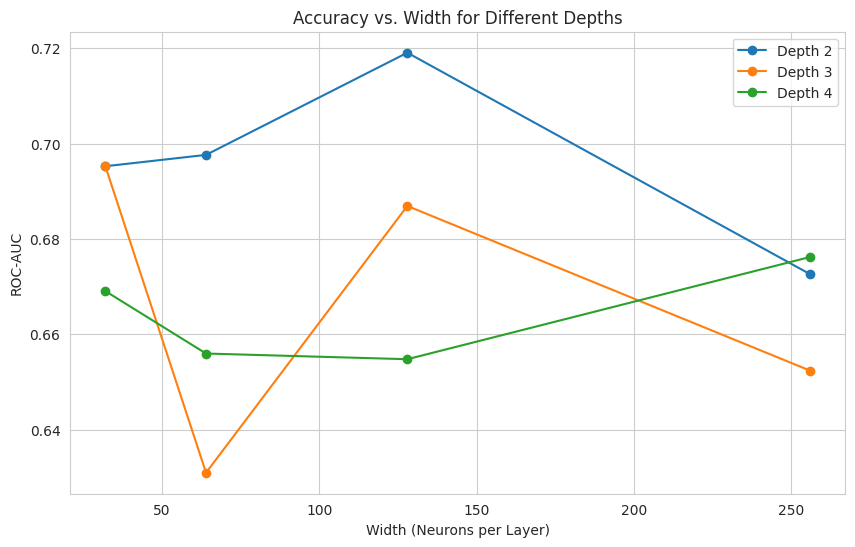

In [38]:
# Set Seaborn style for better visualization
sns.set_style("whitegrid")

# Plot accuracy vs. width for different depths
plt.figure(figsize=(10, 6))

for depth in depths:
    subset = final_simple_results_df[final_simple_results_df["Depth"] == depth]
    plt.plot(subset["Width"], subset["ROC-AUC"], marker='o', label=f"Depth {depth}")

plt.xlabel("Width (Neurons per Layer)")
plt.ylabel("ROC-AUC")
plt.title("Accuracy vs. Width for Different Depths")
plt.legend()
plt.show()


# Analysis of MLP Model using Hypertuning

## Building the MLP with parameters

In [39]:
X_train = X_train_copy.copy()
y_train = y_train_copy.copy()
X_val = X_val_copy.copy()
y_val = y_val_copy.copy()
X_test = X_test_copy.copy()
y_test = y_test_copy.copy()

In [40]:
# Function to build an MLP model with dropout & L2 regularization

def build_mlp(depth=2, width=64, l2_lambda=0.01, dropout_rate=0.3):
    model =  keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))  # Input Layer (Automatically derived from X_train)

    # Add hidden layers with L2 regularization & dropout
    for _ in range(depth):
        model.add(layers.Dense(width, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
        model.add(layers.Dropout(dropout_rate))  # Dropout for regularization

    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model



## Training the tuned model

In [41]:
# Function to train and evaluate the MLP model
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, depth, width, epochs=50, batch_size=32):
    print(f"\nTraining MLP Model with Depth={depth}, Width={width}")

    # Build the model
    model = build_mlp(depth=depth, width=width)

    # Early stopping to prevent overfitting
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
                        validation_data=(X_val, y_val), class_weight=class_weights_dict,
                        callbacks=[early_stopping])

    # Predict on test set
    y_pred = (model.predict(X_test, batch_size=batch_size, verbose=0) > 0.5).astype("int32")

    # Calculate evaluation metrics
    results = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred)
    }

    print(f"Accuracy: {results['Accuracy']:.4f}, Precision: {results['Precision']:.4f}, "
          f"Recall: {results['Recall']:.4f}, F1-Score: {results['F1-Score']:.4f}, "
          f"ROC-AUC: {results['ROC-AUC']:.4f}\n")

    return history,model,results



## Expermenting the model with combinations of widths and depths

In [42]:
# Function to run experiments with different depths and widths
def run_experiments(X_train, y_train, X_val, y_val, X_test, y_test, depths, widths, epochs=50, batch_size=32):
    results = []  # Store results for all experiments

    for depth in depths:
        for width in widths:
            try:
                # Train and evaluate model
                history,model, metrics = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, depth, width, epochs, batch_size)

                # Store results
                results.append({
                    'Depth': depth,
                    'Width': width,
                    'Accuracy': metrics['Accuracy'],
                    'Precision': metrics['Precision'],
                    'Recall': metrics['Recall'],
                    'F1-Score': metrics['F1-Score'],
                    'ROC-AUC': metrics['ROC-AUC']
                })

                print(f"Completed: Depth={depth}, Width={width}, AUC-ROC={metrics['ROC-AUC']:.4f}")

            except Exception as e:
                print(f"Error with Depth={depth}, Width={width}: {e}")

    return pd.DataFrame(results)  # Convert results to DataFrame for easy visualization

# Define different depths and widths to experiment with
depths = [2, 3, 4]  # Number of hidden layers
widths = [32, 64, 128,256]  # Number of neurons per layer

# Run experiments and store results
results_df = run_experiments(X_train, y_train, X_val, y_val, X_test, y_test, depths, widths)
final_results_df=pd.DataFrame(results_df)
# Display results
print("\n Experiment Results:")
final_results_df.head(20)


Training MLP Model with Depth=2, Width=32
Accuracy: 0.7300, Precision: 0.5341, Recall: 0.7833, F1-Score: 0.6351, ROC-AUC: 0.7452

Completed: Depth=2, Width=32, AUC-ROC=0.7452

Training MLP Model with Depth=2, Width=64
Accuracy: 0.7250, Precision: 0.5281, Recall: 0.7833, F1-Score: 0.6309, ROC-AUC: 0.7417

Completed: Depth=2, Width=64, AUC-ROC=0.7417

Training MLP Model with Depth=2, Width=128
Accuracy: 0.7000, Precision: 0.5000, Recall: 0.7167, F1-Score: 0.5890, ROC-AUC: 0.7048

Completed: Depth=2, Width=128, AUC-ROC=0.7048

Training MLP Model with Depth=2, Width=256
Accuracy: 0.7150, Precision: 0.5172, Recall: 0.7500, F1-Score: 0.6122, ROC-AUC: 0.7250

Completed: Depth=2, Width=256, AUC-ROC=0.7250

Training MLP Model with Depth=3, Width=32
Accuracy: 0.7350, Precision: 0.5422, Recall: 0.7500, F1-Score: 0.6294, ROC-AUC: 0.7393

Completed: Depth=3, Width=32, AUC-ROC=0.7393

Training MLP Model with Depth=3, Width=64
Accuracy: 0.7100, Precision: 0.5122, Recall: 0.7000, F1-Score: 0.5915, RO

,Depth,Width,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,2,32,0.730,0.534091,0.783333,0.635135,0.745238
1,2,64,0.725,0.528090,0.783333,0.630872,0.741667
2,2,128,0.700,0.500000,0.716667,0.589041,0.704762
3,2,256,0.715,0.517241,0.750000,0.612245,0.725000
4,3,32,0.735,0.542169,0.750000,0.629371,0.739286
5,3,64,0.710,0.512195,0.700000,0.591549,0.707143
6,3,128,0.715,0.517241,0.750000,0.612245,0.725000
7,3,256,0.720,0.525641,0.683333,0.594203,0.709524
8,4,32,0.745,0.555556,0.750000,0.638298,0.746429
9,4,64,0.740,0.552632,0.700000,0.617647,0.728571


## Best model with Accuracy/ROC-AUC

In [43]:
# Sort the results by Accuracy (or ROC-AUC, Precision, etc.) in descending order
best_model_row = final_results_df.sort_values(by='Accuracy', ascending=False).iloc[0]

# Extract the best model's parameters and results
best_depth = best_model_row['Depth']
best_width = best_model_row['Width']
best_accuracy = best_model_row['Accuracy']
best_precision = best_model_row['Precision']
best_recall = best_model_row['Recall']
best_f1_score = best_model_row['F1-Score']
best_roc_auc = best_model_row['ROC-AUC']

# Display the best model's parameters and metrics
print(f"Best Model Based on Accuracy:")
print(f"Depth: {best_depth}, Width: {best_width}")
print(f"Accuracy: {best_accuracy:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, "
      f"F1-Score: {best_f1_score:.4f}, ROC-AUC: {best_roc_auc:.4f}")

best_model_roc = final_results_df.sort_values(by='ROC-AUC', ascending=False).iloc[0]

# Extract the best model's parameters and results
best_depth = best_model_roc['Depth']
best_width = best_model_roc['Width']
best_accuracy = best_model_roc['Accuracy']
best_precision = best_model_roc['Precision']
best_recall = best_model_roc['Recall']
best_f1_score = best_model_roc['F1-Score']
best_roc_auc = best_model_roc['ROC-AUC']

# Display the best model's parameters and metrics
print(f"Best Model Based on ROC:")
print(f"Depth: {best_depth}, Width: {best_width}")
print(f"Accuracy: {best_accuracy:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, "
      f"F1-Score: {best_f1_score:.4f}, ROC-AUC: {best_roc_auc:.4f}")


Best Model Based on Accuracy:
Depth: 4.0, Width: 32.0
Accuracy: 0.7450, Precision: 0.5556, Recall: 0.7500, F1-Score: 0.6383, ROC-AUC: 0.7464
Best Model Based on ROC:
Depth: 4.0, Width: 32.0
Accuracy: 0.7450, Precision: 0.5556, Recall: 0.7500, F1-Score: 0.6383, ROC-AUC: 0.7464


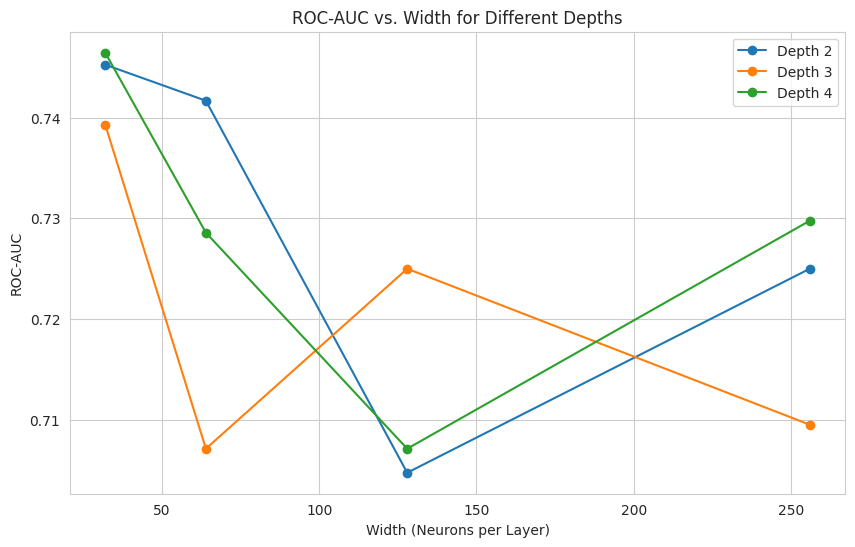

In [44]:
# Set Seaborn style for better visualization
sns.set_style("whitegrid")

# Plot accuracy vs. width for different depths
plt.figure(figsize=(10, 6))

for depth in depths:
    subset = final_results_df[final_results_df["Depth"] == depth]
    plt.plot(subset["Width"], subset["ROC-AUC"], marker='o', label=f"Depth {depth}")

plt.xlabel("Width (Neurons per Layer)")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC vs. Width for Different Depths")
plt.legend()
plt.show()


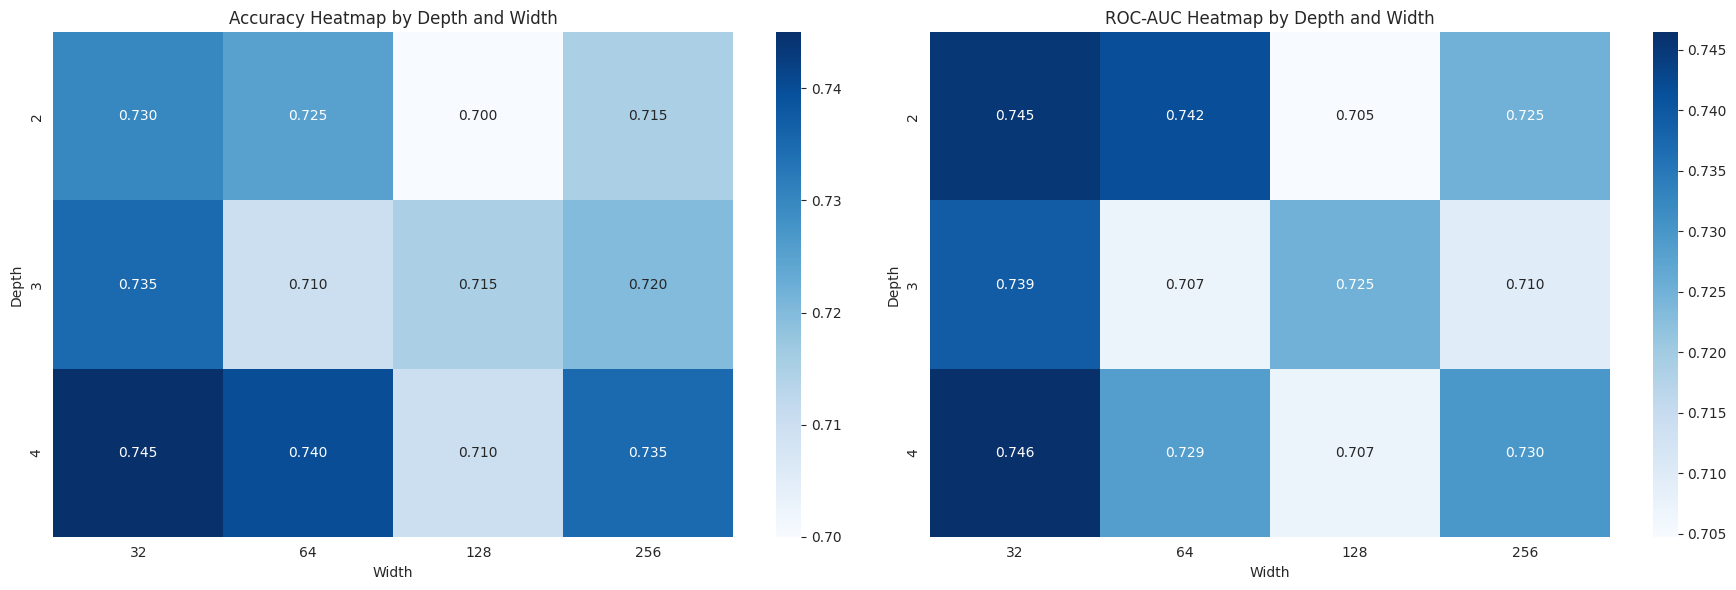

In [45]:
# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Visualize results as a heatmap (Accuracy) on the first subplot
pivot_table = results_df.pivot(index="Depth", columns="Width", values="Accuracy")
sns.heatmap(pivot_table, annot=True, cmap="Blues", fmt=".3f", cbar=True, ax=axes[0])
axes[0].set_title('Accuracy Heatmap by Depth and Width')

# Visualize ROC-AUC as a heatmap on the second subplot
pivot_table_roc_auc = results_df.pivot(index="Depth", columns="Width", values="ROC-AUC")
sns.heatmap(pivot_table_roc_auc, annot=True, cmap="Blues", fmt=".3f", cbar=True, ax=axes[1])
axes[1].set_title('ROC-AUC Heatmap by Depth and Width')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()



 # Confusion matrix for best model


Training MLP Model with Depth=4, Width=32
Accuracy: 0.7350, Precision: 0.5443, Recall: 0.7167, F1-Score: 0.6187, ROC-AUC: 0.7298

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


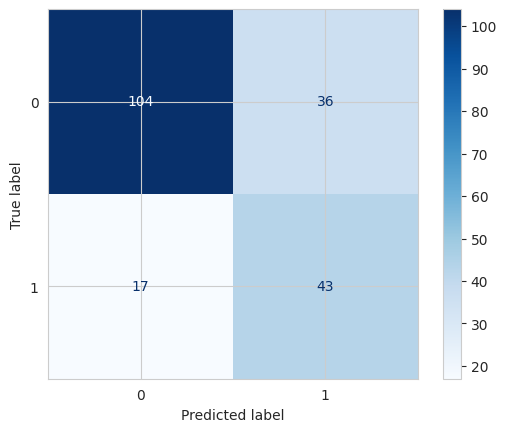

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Train and evaluate the best model
best_depth = 4
best_width = 32

history,best_model, best_model_results = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, depth=best_depth, width=best_width)

# Use trained model to predict on test set
y_prob = best_model.predict(X_test)  # Get probability scores
y_pred = (y_prob > 0.5).astype("int32")  # Convert to binary labels

# Compute and display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

